In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import json
from matplotlib import gridspec
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

/var/folders/6q/mf34xxzn0z5dqtn70dvhsqyh0000gn/T/ipykernel_16508/251986998.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Setup:

LED -> PMT -> $I_{Anode}$

PMT response as a function the input signal $l$ is parameterized as

$R_{PMT} (l) = l + b l^2 + c l^3 + d l^4$

$l$ is defined as $l=G L_i $, where $G$ is the PMT gain, $L_i$ is the input signal intensity in the $ith$ filter wheel position.  

It is assumed $G$ is the same for every filter wheel position.

If PMT is linear, expect parameters $b,c,d$ to be zero.

---

At the ith filter wheel position, the measured anode current in the "Low" position (only constant LED is on) is:

$I_{Anode,L} (i) = R_{PMT} (f_i L_0^{constant} )$

$L_0^{constant}$ is the  input signal intensity at the open filter wheel setting when only the constant LED is on.

The measured anode current in the "High" position is:

$I_{Anode,H} (i) = R_{PMT} (f_i (L_0^{constant} + L_0^{flashing} )) = R_{PMT} (f_i L_0^{constant} (1 + A ))$ 

$L_0^{flashing}$ is the  input signal intensity at the open filter wheel setting when only the flashing LED is on 

$A = L_0^{flashing}/L_0^{constant}$.

---

The average anode current is:

$I_{Anode} (i) =  \frac{I_{Anode,H} (i)  + I_{Anode,L} (i)}{2}$

The measured asymmetry is:

$A_{meas}(i) =  \frac{I_{Anode,H} (i)  - I_{Anode,L} (i)}{I_{Anode,H} (i)  + I_{Anode,L} (i)} $

---

There are five parameters:

$L_0^{constant},A,b,c,d$

As we have measurements from 9 filter wheels positions, we can fit to determine these parameters.



In [38]:
def PMTresponse(input_signal_intensity,b,c,d):
    return (input_signal_intensity + b*(input_signal_intensity**2) + c*(input_signal_intensity**3) + d*(input_signal_intensity**4))

def LEDHigh():
    return 1

def LEDLow(A):
    return A

def LEDSigH(LL,A):
    return LL*(LEDHigh()+LEDLow(A))

def LEDSigL(LL):
    return LL*LEDHigh()

def PMTMeasH(LL,A,b,c,d):
    return PMTresponse(LEDSigH(LL,A),b,c,d)

def PMTMeasL(LL,b,c,d):
    return PMTresponse(LEDSigL(LL),b,c,d)

#from filter wheel datasheet
Fs = [1,.79,.63,.50,.40,.32,.25,.10,.05]

#compute avg anode current and measured asymmetry for given set of parameters
def measAsymPoint(LightLevel,A,b,c,d):
    measH = PMTMeasH(LightLevel,A,b,c,d)
    measL = PMTMeasL(LightLevel,b,c,d)
    avgcurrent=0.5*(measH+measL)
    asym=(measH-measL)/avgcurrent
    return avgcurrent,asym

#used to compute avg anode current and measured asymmetry for range of light levels
def measRun(LightLevel,A,b,c,d,Fsin=Fs):
    vals_I=[]
    vals_asym=[]
    for i in Fsin:
        resI,resAsym = measAsymPoint(LightLevel*i,A,b,c,d)
        vals_I.append(resI)
        vals_asym.append(resAsym)        
    return vals_I,vals_asym

#global arrays to store measurement data used in functiontominimize(parms)
temp_measI=[]
temp_measA=[]
temp_measIErr=[]
temp_measAErr=[]

# computes distance from prection and measurement.  
# want to find the parms that mimimize this.
def functiontominimize(parms):
    dist=0.0
    LightLevel=parms[0]
    A=parms[1]
    b=parms[2]
    c=parms[3]
    d=parms[4]
    for i in range(0,len(Fs)):
        resI,resAsym = measAsymPoint(LightLevel*Fs[i],A,b,c,d)
#         dist = dist + (((resI-temp_measI[i])/temp_measI[i])**2 + ((resAsym-temp_measA[i])/temp_measA[i])**2) 
        dist = dist + ((resI-temp_measI[i])/temp_measIErr[i])**2 + ((resAsym-temp_measA[i])/temp_measAErr[i])**2
#         dist = dist +  ((resAsym-temp_measA[i])/temp_measAErr[i])**2
    return dist

# performs fit to determine optimal parameters
def performMinimization():
    inital_guess = [12,0.056,-0.04,0,0]
    res = minimize(functiontominimize, inital_guess)
    return res

# for alternate methed used to extract PMT response directly 
def directMethod(x,L0,b,c,d):
    return PMTresponse(x*L0,b,c,d)

def performDirectFit(measI):
    inital_guess2 = [1,0.08,-0.01,0]
    parametersFitResult2=inital_guess2
    parametersFitResult2, parametersCovarianceMatrix2 = curve_fit(directMethod, Fs,measI,absolute_sigma=0, p0=inital_guess2)
    return parametersFitResult2,parametersCovarianceMatrix2


In [42]:
def analyzePMT(measI,measIErr,measA,measAErr,measH,measL):
    
    res = performMinimization()    
            
    Ifromfit,AsymFromFit = measRun(res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],Fs)
    x_fit2 = np.linspace(0.05, 1, 1000)
    Ifromfit2,AsymFromFit2 = measRun(res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],x_fit2)
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(measI,measA,yerr=measAErr,fmt=".",color="black",label="Data")
    plt.plot(Ifromfit2,AsymFromFit2,'.',c='cornflowerblue',label="Fit Full Prediction")
    plt.plot(Ifromfit,AsymFromFit,'.',c='lightcoral',label="Fit Points")

    plt.ylabel("Measured Asymmetry")
    plt.xlabel(r"Mean Anode Current ($\mu$A)")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(Fs,measI,yerr=np.array(measIErr),fmt=".",label="Data",color="black")
    plt.plot(x_fit2,directMethod(x_fit2,res.x[0],res.x[2],res.x[3],res.x[4]),color="cornflowerblue",label="Fit Full Prediction")
    plt.plot(Fs,directMethod(np.array(Fs),res.x[0],res.x[2],res.x[3],res.x[4]),".",color="lightcoral",label="Fit Points")

    plt.xlabel("Filter Wheel Transmission Setting")
    plt.ylabel(r"Mean Anode Current ($\mu$A)")
    plt.legend()
    plt.show()

In [43]:
with open('Consecutive_runs_database-29.json') as f:
    df = json.load(f)

<Figure size 1000x600 with 0 Axes>

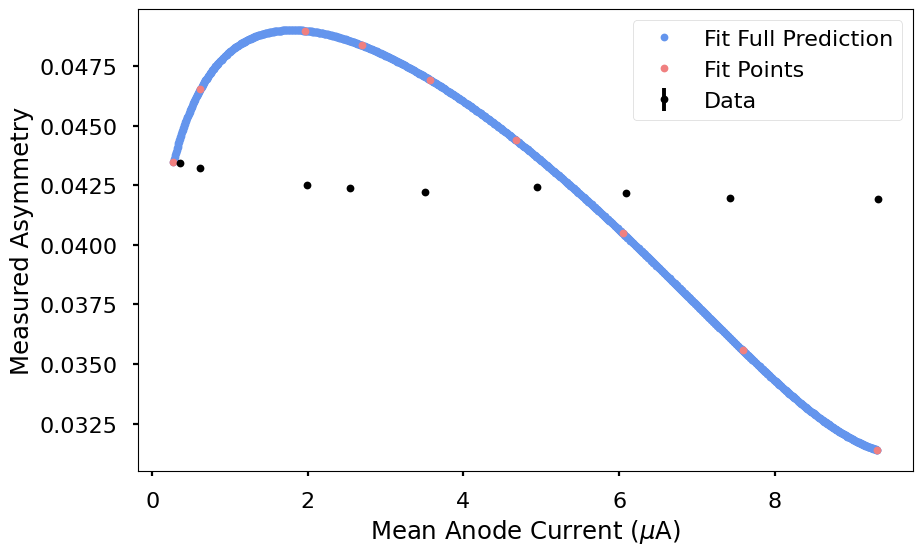

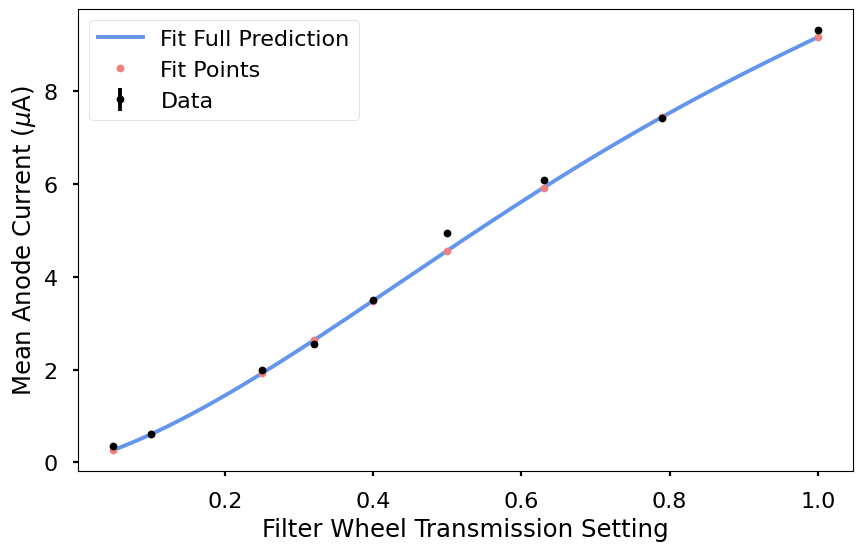

In [44]:
temp_measI_H=[]
temp_measI_L=[]

plt.figure(figsize=(10, 6))
# for j in range(0,2):
for j in range(0,1):
#     for i in range(0,20):
    for i in range(-1,0):
        temp_measI=df[j]['runs'][0]['Anode_current(uA)'][i]
        temp_measIErr=df[j]['runs'][0]['Anode_current_err(uA)'][i]
        temp_measA=df[j]['runs'][0]['Asymmetry'][i]
        temp_measAErr=df[j]['runs'][0]['Asymmetry_err'][i]
        temp_measI_H=df[j]['runs'][0]['Average_H(V)'][i]
        temp_measI_L=df[j]['runs'][0]['Average_L(V)'][i]
        
        analyzePMT(temp_measI,temp_measIErr,temp_measA,temp_measAErr,temp_measI_H,temp_measI_L)
plt.show()